In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### Surprise 패키지 설치

In [4]:
!pip install scikit-surprise

### 데이터 로드 및 패키지 테스트

In [9]:
import numpy as np

from surprise import BaselineOnly
from surprise import KNNWithMeans
from surprise import SVD
from surprise import SVDpp
from surprise import Dataset
from surprise import accuracy
from surprise import Reader
from surprise.model_selection import cross_validate
from surprise.model_selection import train_test_split

data = Dataset.load_builtin('ml-100k')

trainset, testset = train_test_split(data, test_size = 0.25)

algo = KNNWithMeans()
algo.fit(trainset)
predictions = algo.test(testset)
accuracy.rmse(predictions)

Dataset ml-100k could not be found. Do you want to download it? [Y/n] Y
Trying to download dataset from https://files.grouplens.org/datasets/movielens/ml-100k.zip...
Done! Dataset ml-100k has been saved to /root/.surprise_data/ml-100k
Computing the msd similarity matrix...
Done computing similarity matrix.
RMSE: 0.9571


0.957119166212647

### 패키지 내 다양한 알고리즘 비교

Estimating biases using als...
RMSE: 0.9500
Computing the msd similarity matrix...
Done computing similarity matrix.
RMSE: 0.9571
RMSE: 0.9450
RMSE: 0.9235


array([0.92351351, 0.94496756, 0.94997255, 0.95711917])

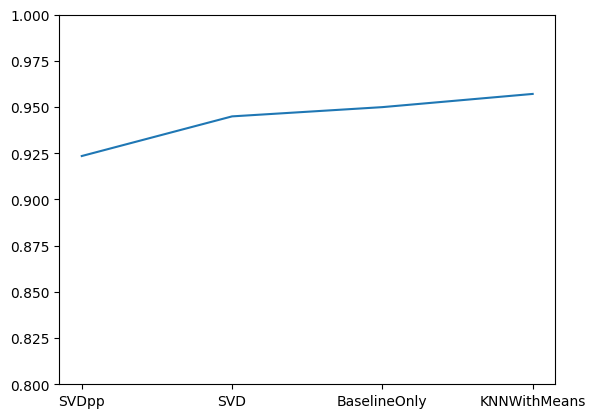

In [10]:
algorithms = [BaselineOnly, KNNWithMeans, SVD, SVDpp]
names = []
results = []
for option in algorithms:
  algo = option()
  names.append(option.__name__)
  algo.fit(trainset)
  predictions = algo.test(testset)
  results.append(accuracy.rmse(predictions))

names = np.array(names)
results = np.array(results)


#결과를 그래프로 표시

import matplotlib.pyplot as plt
index = np.argsort(results)
plt.ylim(0.8, 1)
plt.plot(names[index], results[index])
results[index]

In [11]:
sim_options = {'name': 'pearson_baseline', 'user_based' : True}
algo = KNNWithMeans(k = 30, sim_options = sim_options)
algo.fit(trainset)
predictions = algo.test(testset)
accuracy.rmse(predictions)

Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
RMSE: 0.9453


0.945303690574677

In [13]:
result = []
for neighbor_size in (10, 20, 30, 40, 50, 60):
  algo = KNNWithMeans(k = neighbor_size, sim_options = {'name': 'pearson_baseline', 'user_based' : True})
  algo.fit(trainset)
  predictions = algo.test(testset)
  result.append([neighbor_size, accuracy.rmse(predictions)])

result

Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
RMSE: 0.9617
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
RMSE: 0.9473
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
RMSE: 0.9453
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
RMSE: 0.9449
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
RMSE: 0.9446
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
RMSE: 0.9448


[[10, 0.961672463995458],
 [20, 0.9472984738845284],
 [30, 0.945303690574677],
 [40, 0.9448953466487156],
 [50, 0.9446077884439779],
 [60, 0.9447868241654852]]

### KNN 다양한 파라미터 비교

In [16]:
#KNN 모델 파라미터 비교
from surprise.model_selection import GridSearchCV
param_grid = {'k' : [5, 10, 15, 20], 'sim_options': {'name': ['pearson_baseline', 'cosine'], 'user_based': [True, False]}}
gs = GridSearchCV(KNNWithMeans, param_grid, measures = ['rmse'], cv = 4)
gs.fit(data)

print('Best gs_score: ',  gs.best_score['rmse'])
print('Best gs_params: ',  gs.best_params['rmse'])

Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similar

### SVD 파라미터 비교

In [17]:
from surprise.model_selection import GridSearchCV
param_grid = {'n_epochs': [70, 80, 90, 100],
              'lr_all': [0.005, 0.006, 0.007, 0.008],
              'reg_all': [0.05, 0.07, 0.1]}
gs = GridSearchCV(SVD, param_grid, measures = ['rmse'], cv = 4)
gs.fit(data)

print('Best Score: ', gs.best_score['rmse'])
print('Best Params: ', gs.best_params['rmse'])

Best Score:  0.9125069406258681
Best Params:  {'n_epochs': 90, 'lr_all': 0.006, 'reg_all': 0.1}


### 실제 데이터에 적용

In [19]:
import pandas as pd
r_cols = ['user_id', 'movie_id', 'rating', 'timestamp']
ratings = pd.read_csv('/content/drive/MyDrive/recosys/u.data', sep = '\t', names = r_cols, encoding = 'latin-1')
reader = Reader(rating_scale = (1,5))
data = Dataset.load_from_df(ratings[['user_id', 'movie_id', 'rating']], reader)

In [20]:
#KNN
from surprise.model_selection import GridSearchCV
param_grid = {'k' : [10, 20, 30], 'sim_options': {'name': ['pearson_baseline', 'cosine'], 'user_based': [True, False]}}
gs = GridSearchCV(KNNWithMeans, param_grid, measures = ['rmse'], cv = 4)
gs.fit(data)

print('Best gs_score: ',  gs.best_score['rmse'])
print('Best gs_params: ',  gs.best_params['rmse'])

Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similar